In [1]:
%matplotlib inline

In [1]:
sc

In [2]:
rdd = sc.parallelize(range(1000), 20)

In [3]:
rdd.getNumPartitions()

20

In [2]:
import numpy as np
import scipy.sparse as sps
from pyspark.mllib.linalg import Vectors

ImportError: No module named pyspark.mllib.linalg

In [7]:
sv1 = Vectors.sparse(3, [0, 7], [1.0, 3.0])

# how to deal with the situatio... index > size of vector , sparse...

convert to Array.. error... predict... error.. will try use other index...


In [12]:
sv1.numNonzeros()
sv1

SparseVector(3, {0: 1.0, 7: 3.0})

In [16]:
sv1.values

array([ 1.,  3.])

In [15]:
Vectors.dense(sv1).toSparse()

AttributeError: 'numpy.ndarray' object has no attribute 'toSparse'

## Change

- new subsmapling of data for training and testing
- validation data
- using scikit-learn for evaluation
- investigate Hyper parameters tuning
- using duplicates of different training size to replace cross-validation
- using duplicates of different testing size to replace cross-validation





# Conclusion

- Using balanced subsampling training data can get better performance.. .

[[4665  335]

 [ 597 4403]]
 
- Increasing size of training data does not increase the performance much
- Model is robust, changing randomly subsampling training data or testing data does not change evaluation
- More inbalanced the training data is, the worse the performance is
- Using basically default parameters without tuning, logistic regression works the best, and also is the fastest
- About logistic regression
    - Increasing iteration from 100 to 300 does not increase performance
    - LogisticRegressionWithLBFGS works better than LogisticRegressionWithSGD
    - L1 vs L2, no big change
    
- MGRAST 
    - 54% of real virus segments are classified as virus
    - 99% of real non-virus segments are classified as non-virus



# Todo

- Change to ML based on DataFrame
- pipeline... using full testing data set to evaluate performance
- using pipeline interface.. of spark... cross validation... and other algoriths... and select best models...
- testing on all testing data sets....


## New Idea
- multiple class -> binary class.. method???
- inblanced data....
- large data
- different kind of features... to integrate...


In [7]:
from pyspark.mllib.util import MLUtils
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt

from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint


In [8]:
from sklearn.metrics import average_precision_score

50000 training segments....

25k virus

25k non-virus


In [12]:
def evaluate_model(testing, model):
    model.clearThreshold()
    labelsAndScores = testing.map(lambda p: (p.label, model.predict(p.features)))
    LS = labelsAndScores.collect()
    y_true = []
    y_scores = []
    for s in LS:
        y_true.append(s[0])
        y_scores.append(s[1])
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    au_PRC = average_precision_score(y_true, y_scores)
    return au_PRC, precision, recall, thresholds

In [9]:
def testing_model(testing, model):
    # not useful any more... use evaluate_model instead
    labelsAndPreds = testing.map(lambda p: (p.label, model.predict(p.features)))
    Err = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(testing.count())
    
    LP = labelsAndPreds.collect()
    
    label_list = []
    prediction = []
    for t in LP:
        label_list.append(t[0])
        prediction.append(t[1])
    matrix = confusion_matrix(label_list, prediction)
    model.clearThreshold()
    labelsAndScores = testing.map(lambda p: (p.label, model.predict(p.features)))
    labelsAndScores_list = labelsAndScores.collect()

    y_true = []
    y_scores = []
    for t in LP:
        y_true.append(t[0])
        y_scores.append(t[1])
        
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    return [Err, matrix, precision, recall]


## Standard, family level, logistic regression, all features


required files:

training.vect

testing.vect

all_segment.fasta.vect
all_segment.fasta.vect.family.testing.svmlib
all_segment.fasta.vect.family.testing.svmlib.no4
all_segment.fasta.vect.family.testing.svmlib.no4.non_virus



### Get 25k and 5k randomly selected vectors from full training and testing vector files, for virus/non-virus

qpzhang@genepool14:/global/projectb/scratch/qpzhang/Run_Genelearn/Full_nextflow$ more random_lines.sh
```
python random_lines.py all_segment.fasta.vect.family.testing.svmlib.no4.virus 58000 5000 >virus_testing_5k.vect &
python random_lines.py all_segment.fasta.vect.family.testing.svmlib.no4.non_virus 1579000 5000 >non_virus_testing_5k.vect &
python random_lines.py all_segment.fasta.vect.family.training.svmlib.no4.virus 150600 25000 >virus_training_25k.vect &
python random_lines.py all_segment.fasta.vect.family.training.svmlib.no4.non_virus 5076200 25000 >non_virus_training_25k.vect &
```




```
cat non_virus_training_25k.vect virus_training_25k.vect > training.vect
cat non_virus_testing_5k.vect virus_testing_5k.vect >testing.vect
```



In [9]:
training = MLUtils.loadLibSVMFile(sc, "training.vect")
training.cache()
testing = MLUtils.loadLibSVMFile(sc, "testing.vect",19421)
testing.cache()
model_logistic = LogisticRegressionWithLBFGS.train(training)
model_logistic.clearThreshold()
labelsAndScores = testing.map(lambda p: (p.label, model_logistic.predict(p.features)))

In [10]:
LS = labelsAndScores.collect()


score_virus = []
score_nonvirus = []
for s in LS:
    if s[0] == 0.0:
        score_nonvirus.append(s[1])
    else:
        score_virus.append(s[1])
    
    

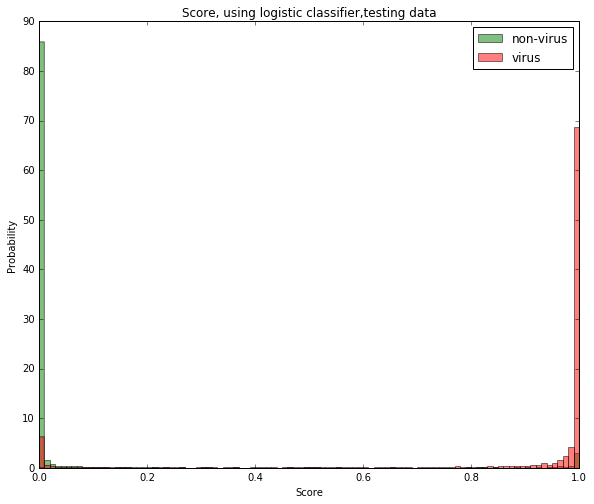

In [11]:
plt.figure(figsize=(10, 8), dpi=80)
num_bins = 100
# the histogram of the data
n, bins, patches = plt.hist(score_nonvirus, num_bins, normed=1, facecolor='green', alpha=0.5, label='non-virus')
n, bins, patches = plt.hist(score_virus, num_bins, normed=1, facecolor='red', alpha=0.5, label = 'virus')

plt.xlabel('Score')
plt.ylabel('Probability')
plt.title('Score, using logistic classifier,testing data')
plt.legend()
# Tweak spacing to prevent clipping of ylabel
plt.subplots_adjust(left=0.15)
plt.show()

In [14]:
result = evaluate_model(testing, model_logistic)

In [15]:
result

(0.9418798233834007,
 array([ 0.5       ,  0.69936435,  0.70185615, ...,  0.95063215,
         0.95048309,  1.        ]),
 array([ 1.    ,  0.9682,  0.968 , ...,  0.3158,  0.3148,  0.    ]),
 array([  9.44258261e-176,   4.60682710e-007,   5.20437119e-007, ...,
          9.99999492e-001,   9.99999584e-001,   9.99999623e-001]))

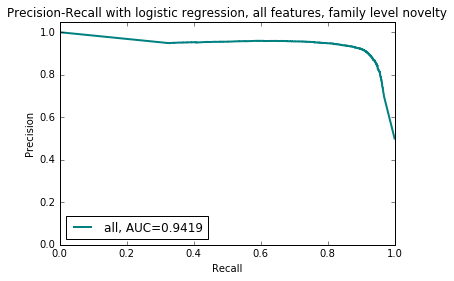

In [17]:
lw = 2
plt.figure(figsize=(6, 4), dpi=80)

# Plot Precision-Recall curve
plt.clf()

plt.plot(result[2], result[1], lw=lw, color='teal',
         label='all, AUC={0:0.4f}'.format(result[0]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall with logistic regression, all features, family level novelty')
plt.legend(loc="lower left")
plt.show()


## Testing different features


to deal with dimension mismatch

- get vector size of training data set, and restrict the size of testing data.. no larger than size of training


```
python ~/GDrive/Development/Bitbucket/jgi-genelearn/scripts/pick_vectors_by_feature.py -d all_segment.fasta.vect.feature_index -f 0 -i testing.vect -o testing.vect.0
python ~/GDrive/Development/Bitbucket/jgi-genelearn/scripts/pick_vectors_by_feature.py -d all_segment.fasta.vect.feature_index -f 1 -i testing.vect -o testing.vect.1
python ~/GDrive/Development/Bitbucket/jgi-genelearn/scripts/pick_vectors_by_feature.py -d all_segment.fasta.vect.feature_index -f 2 -i testing.vect -o testing.vect.2
python ~/GDrive/Development/Bitbucket/jgi-genelearn/scripts/pick_vectors_by_feature.py -d all_segment.fasta.vect.feature_index -f 3 -i testing.vect -o testing.vect.3
python ~/GDrive/Development/Bitbucket/jgi-genelearn/scripts/pick_vectors_by_feature.py -d all_segment.fasta.vect.feature_index -f 4 -i testing.vect -o testing.vect.4
python ~/GDrive/Development/Bitbucket/jgi-genelearn/scripts/pick_vectors_by_feature.py -d all_segment.fasta.vect.feature_index -f 0_1 -i testing.vect -o testing.vect.0_1
python ~/GDrive/Development/Bitbucket/jgi-genelearn/scripts/pick_vectors_by_feature.py -d all_segment.fasta.vect.feature_index -f 0_1_2 -i testing.vect -o testing.vect.0_1_2
python ~/GDrive/Development/Bitbucket/jgi-genelearn/scripts/pick_vectors_by_feature.py -d all_segment.fasta.vect.feature_index -f 0_1_2_3 -i testing.vect -o testing.vect.0_1_2_3

```

In [65]:
testing_list = ['testing.vect.0', 'testing.vect.0_1', 'testing.vect.0_1_2', 'testing.vect.0_1_2_3', 'testing.vect']
training_list = ['training.vect.0', 'training.vect.0_1', 'training.vect.0_1_2', 'training.vect.0_1_2_3','training.vect']
training_vector_size = [135, 391, 14377, 19421, 19421]

In [69]:
def evaluate_features(training_list, testing_list,training_vector_size ):
    
    result_list = []
    for i in range(len(training_list)):
        training = MLUtils.loadLibSVMFile(sc, training_list[i])
        training.cache()
        model = LogisticRegressionWithLBFGS.train(training)
        testing = MLUtils.loadLibSVMFile(sc, testing_list[i], training_vector_size[i])
        testing.cache()
        result = evaluate_model(testing, model)
        result_list.append(result)
        print result_list
    return result_list
        

In [ ]:
result_list = evaluate_features(training_list, testing_list,training_vector_size )

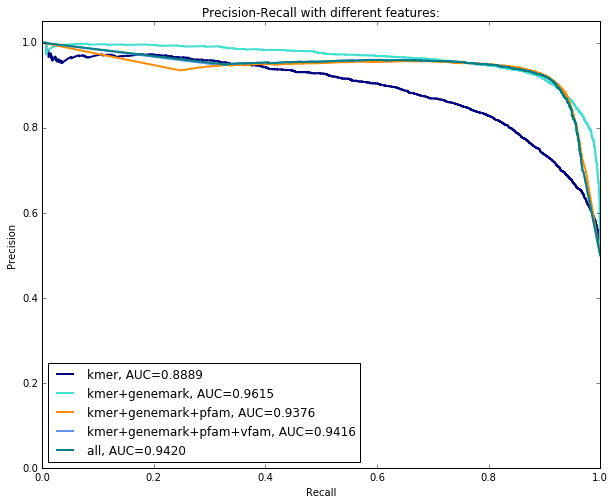

In [76]:
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
lw = 2
plt.figure(figsize=(10, 8), dpi=80)

# Plot Precision-Recall curve
plt.clf()
plt.plot(result_list[0][2], result_list[0][1], lw=lw, color='navy',
         label='kmer, AUC={0:0.4f}'.format(result_list[0][0]))
plt.plot(result_list[1][2], result_list[1][1], lw=lw, color='turquoise',
         label='kmer+genemark, AUC={0:0.4f}'.format(result_list[1][0]))
plt.plot(result_list[2][2], result_list[2][1], lw=lw, color='darkorange',
         label='kmer+genemark+pfam, AUC={0:0.4f}'.format(result_list[2][0]))
plt.plot(result_list[3][2], result_list[3][1], lw=lw, color='cornflowerblue',
         label='kmer+genemark+pfam+vfam, AUC={0:0.4f}'.format(result_list[3][0]))
plt.plot(result_list[4][2], result_list[4][1], lw=lw, color='teal',
         label='all, AUC={0:0.4f}'.format(result_list[4][0]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall with different features:')
plt.legend(loc="lower left")
plt.show()


## testing on diffferent taxonomic level

In [18]:
training_order = MLUtils.loadLibSVMFile(sc, "order_training_25k.vect.sorted")
training_order.cache()

training_genus = MLUtils.loadLibSVMFile(sc, "genus_training_25k.vect.sorted")
training_genus.cache()

PythonRDD[487] at RDD at PythonRDD.scala:48

In [19]:
model_logistic_order = LogisticRegressionWithLBFGS.train(training_order)
model_logistic_genus = LogisticRegressionWithLBFGS.train(training_genus)

In [20]:
testing_order = MLUtils.loadLibSVMFile(sc, "order_testing_25k.vect.sorted",37373)
testing_genus = MLUtils.loadLibSVMFile(sc, "genus_testing_25k.vect.sorted",37373)


In [21]:
logistic_result_order = evaluate_model(testing_order,model_logistic_order)


In [23]:
logistic_result_genus = evaluate_model(testing_genus,model_logistic_genus)


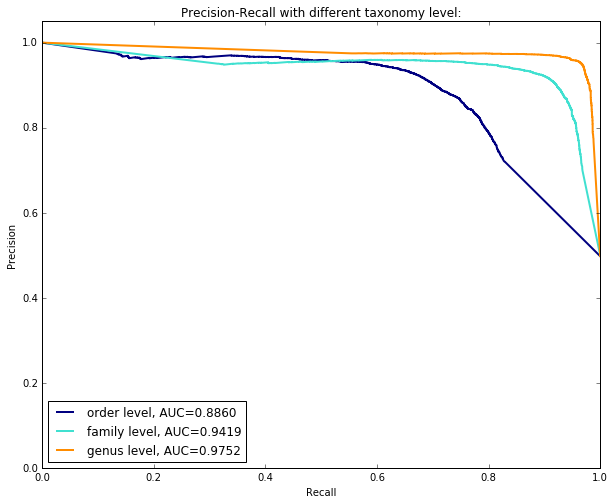

In [25]:
lw = 2
plt.figure(figsize=(10, 8), dpi=80)

# Plot Precision-Recall curve
plt.clf()
plt.plot(logistic_result_order[2], logistic_result_order[1], lw=lw, color='navy',
         label='order level, AUC={0:0.4f}'.format(logistic_result_order[0]))
plt.plot(result[2], result[1], lw=lw, color='turquoise',
         label='family level, AUC={0:0.4f}'.format(result[0]))
plt.plot(logistic_result_genus[2], logistic_result_genus[1], lw=lw, color='darkorange',
         label='genus level, AUC={0:0.4f}'.format(logistic_result_genus[0]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall with different taxonomy level:')
plt.legend(loc="lower left")
plt.show()

In [91]:
MEGAN_precision_order = 3/(3+61.0)
MEGAN_recall_order = 3/4916.0
MEGAN_precision_family = 858/(858+60.0)
MEGAN_recall_family = 858/4916.0
MEGAN_precision_genus = 1695/(1695+26.0)
MEGAN_recall_genus = 1695/4916.0

In [92]:
MEGAN_recall_order,MEGAN_recall_family,MEGAN_recall_genus

(0.0006102522375915378, 0.17453213995117983, 0.34479251423921886)

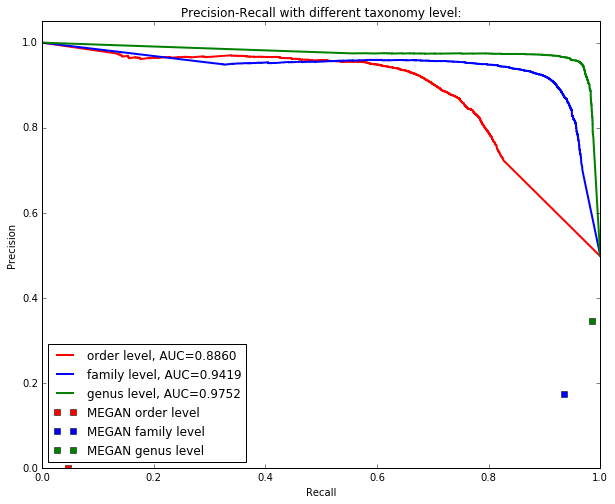

In [95]:
lw = 2
plt.figure(figsize=(10, 8), dpi=80)

# Plot Precision-Recall curve
plt.clf()
plt.plot(logistic_result_order[2], logistic_result_order[1], lw=lw, color='red',
         label='order level, AUC={0:0.4f}'.format(logistic_result_order[0]))
plt.plot(result[2], result[1], lw=lw, color='blue',
         label='family level, AUC={0:0.4f}'.format(result[0]))
plt.plot(logistic_result_genus[2], logistic_result_genus[1], lw=lw, color='green',
         label='genus level, AUC={0:0.4f}'.format(logistic_result_genus[0]))
plt.plot([MEGAN_precision_order], [MEGAN_recall_order], 'rs',
         label='MEGAN order level')
plt.plot([MEGAN_precision_family], [MEGAN_recall_family], 'bs',
         label='MEGAN family level')
plt.plot([MEGAN_precision_genus], [MEGAN_recall_genus], 'gs',
         label='MEGAN genus level')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall with different taxonomy level:')
plt.legend(loc="lower left")
plt.show()


In [103]:
MEGAN_precision_order_keep = 3353/(3353+50.0)
MEGAN_recall_order_keep = 3353/4916.0
MEGAN_precision_family_keep = 2213/(2213+48.0)
MEGAN_recall_family_keep = 2213/4916.0
MEGAN_precision_genus_keep = 3600/(3600+26.0)
MEGAN_recall_genus_keep = 3600/4916.0

In [104]:
MEGAN_recall_order_keep, MEGAN_recall_family_keep, MEGAN_recall_genus_keep

(0.6820585842148088, 0.45016273393002443, 0.7323026851098454)

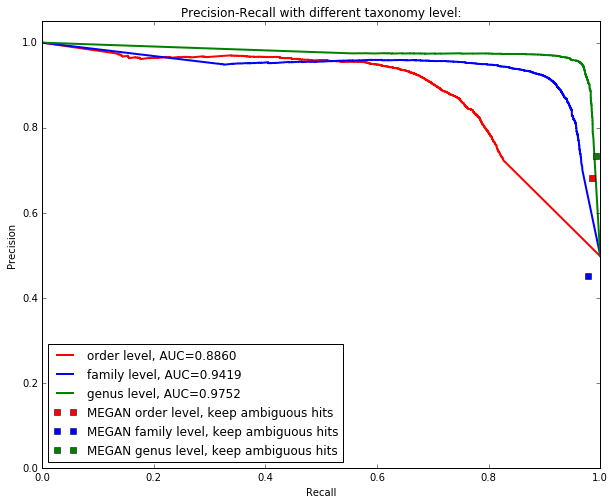

In [105]:
lw = 2
plt.figure(figsize=(10, 8), dpi=80)

# Plot Precision-Recall curve
plt.clf()
plt.plot(logistic_result_order[2], logistic_result_order[1], lw=lw, color='red',
         label='order level, AUC={0:0.4f}'.format(logistic_result_order[0]))
plt.plot(result[2], result[1], lw=lw, color='blue',
         label='family level, AUC={0:0.4f}'.format(result[0]))
plt.plot(logistic_result_genus[2], logistic_result_genus[1], lw=lw, color='green',
         label='genus level, AUC={0:0.4f}'.format(logistic_result_genus[0]))
plt.plot([MEGAN_precision_order_keep], [MEGAN_recall_order_keep], 'rs',
         label='MEGAN order level, keep ambiguous hits')
plt.plot([MEGAN_precision_family_keep], [MEGAN_recall_family_keep], 'bs',
         label='MEGAN family level, keep ambiguous hits')
plt.plot([MEGAN_precision_genus_keep], [MEGAN_recall_genus_keep], 'gs',
         label='MEGAN genus level, keep ambiguous hits')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall with different taxonomy level:')
plt.legend(loc="lower left")
plt.show()



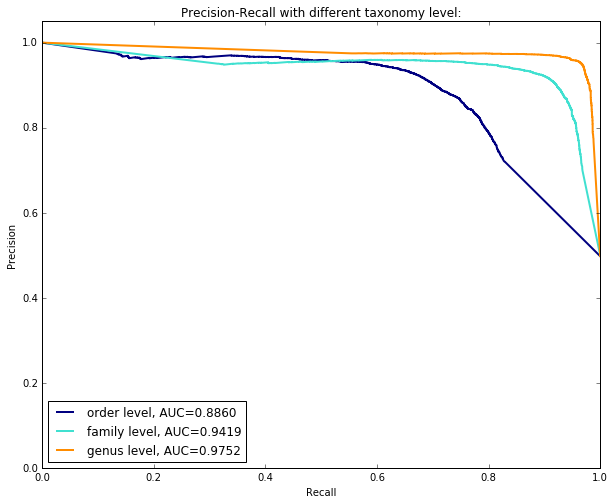

In [99]:
lw = 2
plt.figure(figsize=(10, 8), dpi=80)

# Plot Precision-Recall curve
plt.clf()
plt.plot(logistic_result_order[2], logistic_result_order[1], lw=lw, color='navy',
         label='order level, AUC={0:0.4f}'.format(logistic_result_order[0]))
plt.plot(result[2], result[1], lw=lw, color='turquoise',
         label='family level, AUC={0:0.4f}'.format(result[0]))
plt.plot(logistic_result_genus[2], logistic_result_genus[1], lw=lw, color='darkorange',
         label='genus level, AUC={0:0.4f}'.format(logistic_result_genus[0]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall with different taxonomy level:')
plt.legend(loc="lower left")
plt.show()

### Testing on segments used for MEGAN 

Still in working...

In [19]:
testing_MEGAN_segments = MLUtils.loadLibSVMFile(sc, "virus_nonvirus_segment_5k.fa.vect.svmlilb2",19421)



In [22]:
testing_MEGAN_result = testing_model(testing_MEGAN_segments,model_logistic)

In [24]:
testing_MEGAN_result[1]

array([[4890,  228],
       [1251, 3869]])

In [25]:
testing_MEGAN_result

[0.14446180894705998, array([[4890,  228],
        [1251, 3869]]), array([ 0.50009768,  0.94434952,  1.        ]), array([ 1.        ,  0.75566406,  0.        ])]

## Testing different algorithms

In [26]:
model_logistic_L1 = LogisticRegressionWithLBFGS.train(training,regType='l1')
model_svm = SVMWithSGD.train(training, iterations=100)


In [32]:
logistic_L1_result = evaluate_model(testing,model_logistic_L1 )

In [33]:
SVM_result = evaluate_model(testing,model_svm)

In [29]:
model_svm200 = SVMWithSGD.train(training, iterations=200)

In [30]:
SVM_result200 = evaluate_model(testing,model_svm200)

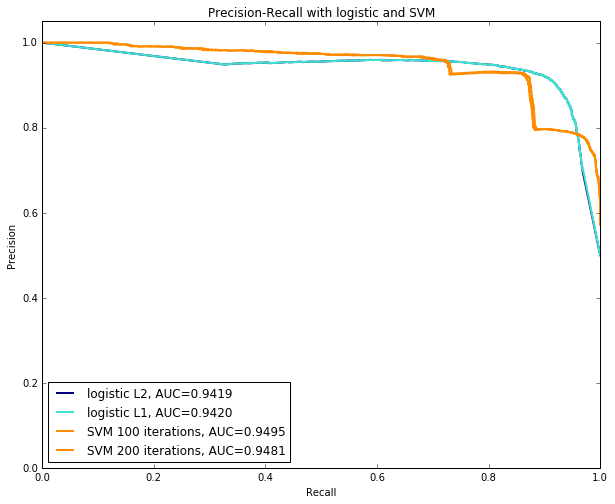

In [35]:
lw = 2
plt.figure(figsize=(10, 8), dpi=80)

# Plot Precision-Recall curve
plt.clf()
plt.plot(result[2], result[1], lw=lw, color='navy',
         label='logistic L2, AUC={0:0.4f}'.format(result[0]))
plt.plot(logistic_L1_result[2], logistic_L1_result[1], lw=lw, color='turquoise',
         label='logistic L1, AUC={0:0.4f}'.format(logistic_L1_result[0]))
plt.plot(SVM_result[2], SVM_result[1], lw=lw, color='darkorange',
         label='SVM 100 iterations, AUC={0:0.4f}'.format(SVM_result[0]))
plt.plot(SVM_result200[2], SVM_result200[1], lw=lw, color='darkorange',
         label='SVM 200 iterations, AUC={0:0.4f}'.format(SVM_result200[0]))


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall with logistic and SVM')
plt.legend(loc="lower left")
plt.show()


## Tree based can't produce precision-recall curve

## Decision Tree Model

In [20]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel

In [21]:
model = DecisionTree.trainClassifier(training, numClasses=2, categoricalFeaturesInfo={},
                                     impurity='gini', maxDepth=3, maxBins=10) # 5,32 out of memory

In [22]:
model

DecisionTreeModel classifier of depth 3 with 15 nodes

difference here with decision Tree model for PySpark!!! ,zip!!

In [23]:
predictions = model.predict(testing.map(lambda x: x.features))

In [24]:
labelsAndPredictions = testing.map(lambda lp: lp.label).zip(predictions)

In [25]:
testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(testing.count())

In [26]:
testErr

0.3126

In [27]:
LP = labelsAndPredictions.collect()
    
label_list = []
prediction = []
for t in LP:
    label_list.append(t[0])
    prediction.append(t[1])
matrix = confusion_matrix(label_list, prediction)

In [28]:
matrix

array([[3401, 1599],
       [1527, 3473]])

In [77]:
precision_decision_tree = 3401/(3401+1527.0)
recall_decision_tree = 3401/(3401+1599.0)

In [74]:
precision
recall

0.690137987012987

## Random Forest

In [29]:
from pyspark.mllib.tree import RandomForest, RandomForestModel

In [30]:
model_rft = RandomForest.trainClassifier(training, numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=3, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=3, maxBins=10)

In [31]:
predictions = model_rft.predict(testing.map(lambda x: x.features))
labelsAndPredictions = testing.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(testing.count())
LP = labelsAndPredictions.collect()
    
label_list = []
prediction = []
for t in LP:
    label_list.append(t[0])
    prediction.append(t[1])
matrix = confusion_matrix(label_list, prediction)

In [32]:
testErr

0.3655

In [33]:
matrix

array([[3672, 1328],
       [2327, 2673]])

In [78]:
precision_rf_tree = 3672/(3672+2327.0)
recall_rf_tree = 3672/(3672+1328.0)

## GBT


In [34]:
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel

In [35]:
model_gbt = GradientBoostedTrees.trainClassifier(training,
                                             categoricalFeaturesInfo={}, numIterations=3)

In [36]:
predictions = model_gbt.predict(testing.map(lambda x: x.features))
labelsAndPredictions = testing.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(testing.count())
LP = labelsAndPredictions.collect()
    
label_list = []
prediction = []
for t in LP:
    label_list.append(t[0])
    prediction.append(t[1])
matrix = confusion_matrix(label_list, prediction)

In [37]:
testErr

0.315

In [38]:
matrix

array([[3559, 1441],
       [1709, 3291]])

In [79]:
precision_gbt_tree = 3559/(3559+1709.0)
recall_gbt_tree = 3559/(3559+1441.0)

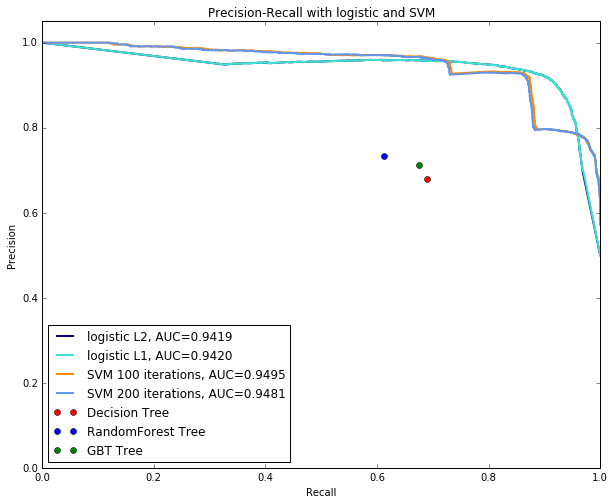

In [97]:
lw = 2
plt.figure(figsize=(10, 8), dpi=80)

# Plot Precision-Recall curve
plt.clf()
plt.plot(result[2], result[1], lw=lw, color='navy',
         label='logistic L2, AUC={0:0.4f}'.format(result[0]))
plt.plot(logistic_L1_result[2], logistic_L1_result[1], lw=lw, color='turquoise',
         label='logistic L1, AUC={0:0.4f}'.format(logistic_L1_result[0]))
plt.plot(SVM_result[2], SVM_result[1], lw=lw, color='darkorange',
         label='SVM 100 iterations, AUC={0:0.4f}'.format(SVM_result[0]))
plt.plot(SVM_result200[2], SVM_result200[1], lw=lw, color='cornflowerblue',
         label='SVM 200 iterations, AUC={0:0.4f}'.format(SVM_result200[0]))
plt.plot([precision_decision_tree], [recall_decision_tree], 'ro',
         label='Decision Tree')
plt.plot([precision_rf_tree], [recall_rf_tree], 'bo',
         label='RandomForest Tree')
plt.plot([precision_gbt_tree], [recall_gbt_tree], 'go',
         label='GBT Tree')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall with logistic and SVM')
plt.legend(loc="lower left")
plt.show()

## Conclusion
Using basically default parameters without tuning, logistic regression works the best, and also is the fastest

# How about larger training data sets?

### Training:
virus 25k + non-virus 25k, 3 duplicates

virus 50k + non-virus 50k, 3 duplicates

virus 100k + non-virus 100k, 3 duplicates

### Same Testing:
virus 5k + non-virus 5k


In [48]:
def evaluate_features_lite(training_list, testing):
    
    result_list = []
    for i in range(len(training_list)):
        training = MLUtils.loadLibSVMFile(sc, training_list[i])
        training.cache()
        model = LogisticRegressionWithLBFGS.train(training)
        result = evaluate_model(testing, model)
        result_list.append(result)
        
    return result_list
        

In [39]:
training_list = []
for k in [25,50,100]:
    for j in [1,2,3]:
        training_list.append("training_"+str(k)+'k_'+str(j)+'.vect')

for k in [50,100,250]:
    training_list.append("training_n"+str(k)+'k_v25k_1.vect')



In [40]:
training_list

['training_25k_1.vect',
 'training_25k_2.vect',
 'training_25k_3.vect',
 'training_50k_1.vect',
 'training_50k_2.vect',
 'training_50k_3.vect',
 'training_100k_1.vect',
 'training_100k_2.vect',
 'training_100k_3.vect',
 'training_n50k_v25k_1.vect',
 'training_n100k_v25k_1.vect',
 'training_n250k_v25k_1.vect']

In [43]:
training_25k_1 = MLUtils.loadLibSVMFile(sc, "training_25k_1.vect")
training_25k_1.cache()
model_logistic_25k_1 = LogisticRegressionWithLBFGS.train(training_25k_1)

training_25k_2 = MLUtils.loadLibSVMFile(sc, "training_25k_2.vect")
training_25k_2.cache()
model_logistic_25k_2 = LogisticRegressionWithLBFGS.train(training_25k_2)

training_25k_3 = MLUtils.loadLibSVMFile(sc, "training_25k_3.vect")
training_25k_3.cache()
model_logistic_25k_3 = LogisticRegressionWithLBFGS.train(training_25k_3)

training_50k_1 = MLUtils.loadLibSVMFile(sc, "training_50k_1.vect")
training_50k_1.cache()
model_logistic_50k_1 = LogisticRegressionWithLBFGS.train(training_50k_1)

training_50k_2 = MLUtils.loadLibSVMFile(sc, "training_50k_2.vect")
training_50k_2.cache()
model_logistic_50k_2 = LogisticRegressionWithLBFGS.train(training_50k_2)

training_50k_3 = MLUtils.loadLibSVMFile(sc, "training_50k_3.vect")
training_50k_3.cache()
model_logistic_50k_3 = LogisticRegressionWithLBFGS.train(training_50k_3)


training_100k_1 = MLUtils.loadLibSVMFile(sc, "training_100k_1.vect")
training_100k_1.cache()
model_logistic_100k_1 = LogisticRegressionWithLBFGS.train(training_100k_1)

training_100k_2 = MLUtils.loadLibSVMFile(sc, "training_100k_2.vect")
training_100k_2.cache()
model_logistic_100k_2 = LogisticRegressionWithLBFGS.train(training_100k_2)


training_100k_3 = MLUtils.loadLibSVMFile(sc, "training_100k_3.vect")
training_100k_3.cache()
model_logistic_100k_3 = LogisticRegressionWithLBFGS.train(training_100k_3)



[0.079, array([[4688,  312],
        [ 478, 4522]]), array([ 0.5       ,  0.93545718,  1.        ]), array([ 1.    ,  0.9044,  0.    ])]

In [ ]:
logistic_100k_1_result

In [ ]:
logistic_50k_2_result

In [ ]:
logistic_50k_3_result

In [ ]:
logistic_100k_2_result

In [ ]:
logistic_100k_3_result

In [ ]:
training_n100k_v25k_1 = MLUtils.loadLibSVMFile(sc, "training_n100k_v25k_1.vect")
training_n100k_v25k_1.cache()
model_logistic_n100k_v25k_1 = LogisticRegressionWithLBFGS.train(training_n100k_v25k_1)
logistic_n100k_v25k_1_result = testing_model(testing,model_logistic_n100k_v25k_1)
logistic_n100k_v25k_1_result

training_n50k_v25k_1 = MLUtils.loadLibSVMFile(sc, "training_n50k_v25k_1.vect")
training_n50k_v25k_1.cache()
model_logistic_n50k_v25k_1 = LogisticRegressionWithLBFGS.train(training_n50k_v25k_1)
logistic_n50k_v25k_1_result = testing_model(testing,model_logistic_n50k_v25k_1)
logistic_n50k_v25k_1_result

training_n250k_v25k_1 = MLUtils.loadLibSVMFile(sc, "training_n250k_v25k_1.vect")
training_n250k_v25k_1.cache()
model_logistic_n250k_v25k_1 = LogisticRegressionWithLBFGS.train(training_n250k_v25k_1)
logistic_n250k_v25k_1_result = testing_model(testing,model_logistic_n250k_v25k_1)
logistic_n250k_v25k_1_result

## Using duplicates of subsampling training set to see how robust the model is

virus 25k + non-virus 25k, 3 duplicates

virus 50k + non-virus 50k, 3 duplicates

virus 100k + non-virus 100k, 3 duplicates

on 

virus 5k + non-virus 5k, as testing data set

In [46]:
training_list_1 = ['training_25k_1.vect', 'training_25k_2.vect', 'training_25k_3.vect']

In [49]:
result_list_1 = evaluate_features_lite(training_list_1, testing)

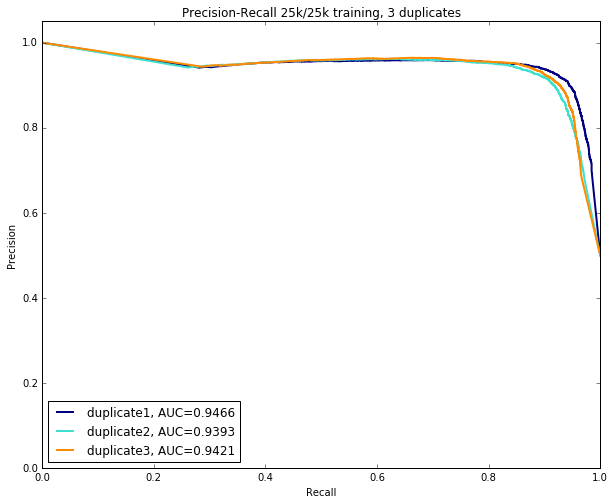

In [52]:
lw = 2
plt.figure(figsize=(10, 8), dpi=80)

# Plot Precision-Recall curve
plt.clf()
plt.plot(result_list_1[0][2], result_list_1[0][1], lw=lw, color='navy',
         label='duplicate1, AUC={0:0.4f}'.format(result_list_1[0][0]))
plt.plot(result_list_1[1][2], result_list_1[1][1], lw=lw, color='turquoise',
         label='duplicate2, AUC={0:0.4f}'.format(result_list_1[1][0]))
plt.plot(result_list_1[2][2], result_list_1[2][1], lw=lw, color='darkorange',
         label='duplicate3, AUC={0:0.4f}'.format(result_list_1[2][0]))


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall 25k/25k training, 3 duplicates')
plt.legend(loc="lower left")
plt.show()


todo: try 50k, 100k, 3 duplicates???

## Using different size of training data 

virus 25k + non-virus 25k

virus 50k + non-virus 50k

virus 100k + non-virus 100k

on

virus 5k + non-virus 5k, as testing data set


In [53]:
training_list_2 = ['training_50k_1.vect', 'training_100k_1.vect']

result_list_2 = evaluate_features_lite(training_list_2, testing)

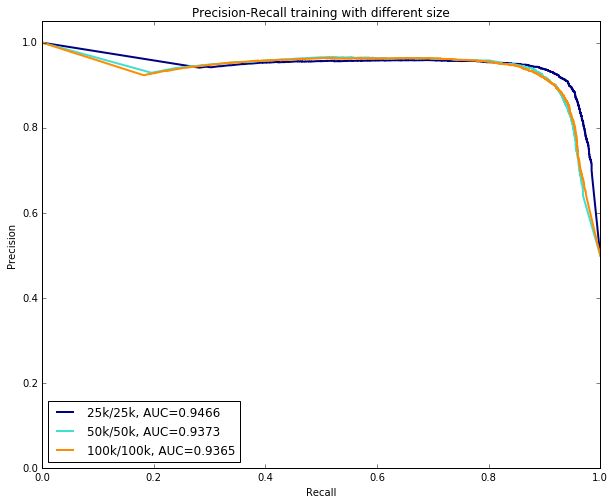

In [55]:
lw = 2
plt.figure(figsize=(10, 8), dpi=80)

# Plot Precision-Recall curve
plt.clf()
plt.plot(result_list_1[0][2], result_list_1[0][1], lw=lw, color='navy',
         label='25k/25k, AUC={0:0.4f}'.format(result_list_1[0][0]))
plt.plot(result_list_2[0][2], result_list_2[0][1], lw=lw, color='turquoise',
         label='50k/50k, AUC={0:0.4f}'.format(result_list_2[0][0]))
plt.plot(result_list_2[1][2], result_list_2[1][1], lw=lw, color='darkorange',
         label='100k/100k, AUC={0:0.4f}'.format(result_list_2[1][0]))


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall training with different size')
plt.legend(loc="lower left")
plt.show()


## Using different iteration number 100 vs 300

In [56]:
model_logistic_i300 = LogisticRegressionWithLBFGS.train(training, iterations=300)


In [57]:
i300_result = evaluate_model(testing, model_logistic_i300)

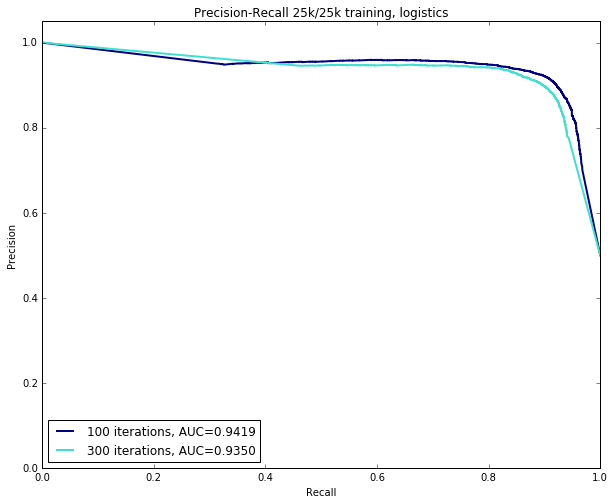

In [59]:
lw = 2
plt.figure(figsize=(10, 8), dpi=80)

# Plot Precision-Recall curve
plt.clf()
plt.plot(result[2], result[1], lw=lw, color='navy',
         label='100 iterations, AUC={0:0.4f}'.format(result[0]))
plt.plot(i300_result[2], i300_result[1], lw=lw, color='turquoise',
         label='300 iterations, AUC={0:0.4f}'.format(i300_result[0]))


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall 25k/25k training, logistics')
plt.legend(loc="lower left")
plt.show()


## LogisticRegressionWithLBFGS vs LogisticRegressionWithSGD

In [60]:
from pyspark.mllib.classification import LogisticRegressionWithSGD, LogisticRegressionModel

model_logistic_SGD = LogisticRegressionWithSGD.train(training)
SGD_result = evaluate_model(testing, model_logistic_SGD)


/Users/qingpeng/Downloads/spark-2.0.2-bin-hadoop2.7/python/pyspark/mllib/classification.py:313: UserWarning: Deprecated in 2.0.0. Use ml.classification.LogisticRegression or LogisticRegressionWithLBFGS.
  "Deprecated in 2.0.0. Use ml.classification.LogisticRegression or "


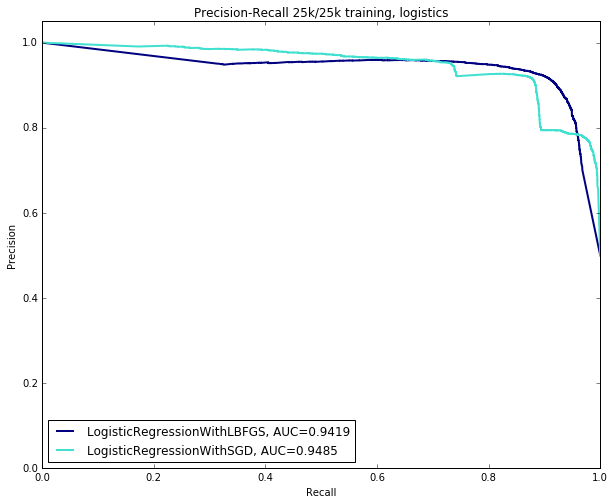

In [61]:
lw = 2
plt.figure(figsize=(10, 8), dpi=80)

# Plot Precision-Recall curve
plt.clf()
plt.plot(result[2], result[1], lw=lw, color='navy',
         label='LogisticRegressionWithLBFGS, AUC={0:0.4f}'.format(result[0]))
plt.plot(SGD_result[2], SGD_result[1], lw=lw, color='turquoise',
         label='LogisticRegressionWithSGD, AUC={0:0.4f}'.format(SGD_result[0]))


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall 25k/25k training, logistics')
plt.legend(loc="lower left")
plt.show()


## How about inbalance data???

25k virus : 25k non-virus

25k virus : 50k non-virus

25k virus : 100k non-virus

In [62]:
training_list_3 = ['training_n50k_v25k_1.vect', 
                   'training_n100k_v25k_1.vect']

result_list_3 = evaluate_features_lite(training_list_2, testing)

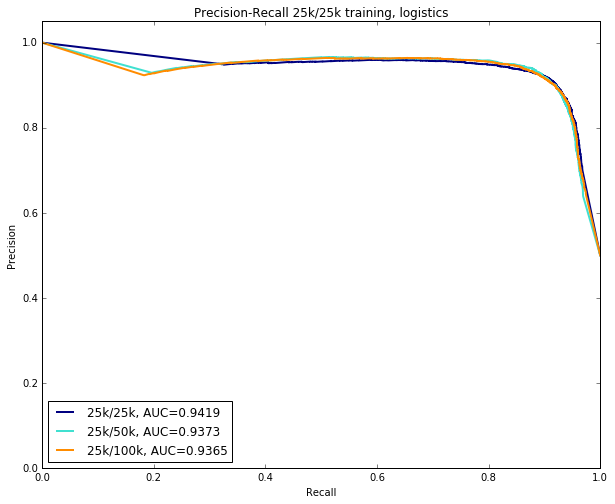

In [69]:
lw = 2
plt.figure(figsize=(10, 8), dpi=80)

# Plot Precision-Recall curve
plt.clf()
plt.plot(result[2], result[1], lw=lw, color='navy',
         label='25k/25k, AUC={0:0.4f}'.format(result[0]))
plt.plot(result_list_3[0][2], result_list_3[0][1], lw=lw, color='turquoise',
         label='25k/50k, AUC={0:0.4f}'.format(result_list_3[0][0]))
plt.plot(result_list_3[1][2], result_list_3[1][1], lw=lw, color='darkorange',
         label='25k/100k, AUC={0:0.4f}'.format(result_list_3[1][0]))


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall 25k/25k training, logistics')
plt.legend(loc="lower left")
plt.show()


## How about using larger testing set? different random testing set?

Testing:

virus 5k + non-virus 5k, 3 duplicates

virus 10k + non-virus 10k, 3 duplicates

virus 20k + non-virus 20k, 3 duplicates





In [64]:
testing_5k_1 = MLUtils.loadLibSVMFile(sc, "testing_5k_1.vect",19421)
testing_5k_1.cache()

testing_5k_2 = MLUtils.loadLibSVMFile(sc, "testing_5k_2.vect",19421)
testing_5k_2.cache()

testing_5k_3 = MLUtils.loadLibSVMFile(sc, "testing_5k_3.vect",19421)
testing_5k_3.cache()



PythonRDD[8805] at RDD at PythonRDD.scala:48

In [65]:
testing_10k_1 = MLUtils.loadLibSVMFile(sc, "testing_10k_1.vect",19421)
testing_10k_1.cache()

testing_20k_1 = MLUtils.loadLibSVMFile(sc, "testing_20k_1.vect",19421)
testing_20k_1.cache()



PythonRDD[8811] at RDD at PythonRDD.scala:48

In [66]:
result_test5k1 = evaluate_model(testing_5k_1, model_logistic)

In [67]:
result_test5k2 = evaluate_model(testing_5k_2, model_logistic)
result_test5k3 = evaluate_model(testing_5k_3, model_logistic)

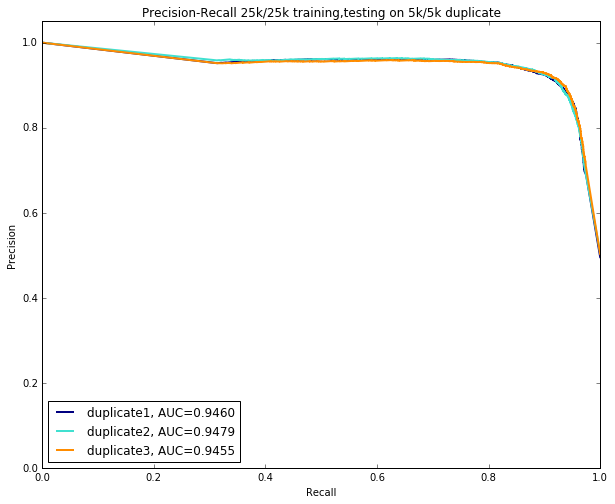

In [70]:
lw = 2
plt.figure(figsize=(10, 8), dpi=80)

# Plot Precision-Recall curve
plt.clf()
plt.plot(result_test5k1[2], result_test5k1[1], lw=lw, color='navy',
         label='duplicate1, AUC={0:0.4f}'.format(result_test5k1[0]))

plt.plot(result_test5k2[2], result_test5k2[1], lw=lw, color='turquoise',
         label='duplicate2, AUC={0:0.4f}'.format(result_test5k2[0]))

plt.plot(result_test5k3[2], result_test5k3[1], lw=lw, color='darkorange',
         label='duplicate3, AUC={0:0.4f}'.format(result_test5k3[0]))


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall 25k/25k training,testing on 5k/5k duplicate')
plt.legend(loc="lower left")
plt.show()


In [71]:
result_test10k1 = evaluate_model(testing_10k_1, model_logistic)
result_test20k1 = evaluate_model(testing_20k_1, model_logistic)

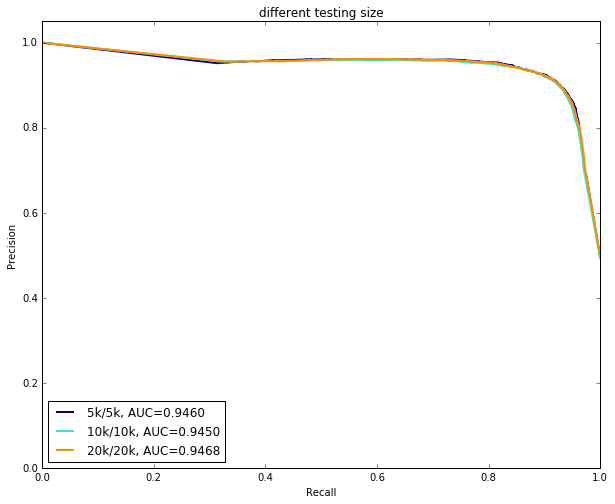

In [72]:
lw = 2
plt.figure(figsize=(10, 8), dpi=80)

# Plot Precision-Recall curve
plt.clf()
plt.plot(result_test5k1[2], result_test5k1[1], lw=lw, color='navy',
         label='5k/5k, AUC={0:0.4f}'.format(result_test5k1[0]))

plt.plot(result_test10k1[2], result_test10k1[1], lw=lw, color='turquoise',
         label='10k/10k, AUC={0:0.4f}'.format(result_test10k1[0]))

plt.plot(result_test20k1[2], result_test20k1[1], lw=lw, color='darkorange',
         label='20k/20k, AUC={0:0.4f}'.format(result_test20k1[0]))


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('different testing size')
plt.legend(loc="lower left")
plt.show()


# Compare to last data sets! randomly 1/50 subset, very inbalanced data


# Compare to MGRast

5k virus segments 

5k non-virus segments



# Using training data to do model selection via train validation split (based on DataFrame, ML)

to do!

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.linalg import Vectors, VectorUDT

In [ ]:
data = spark.read.format("libsvm").load("training.vect")

In [ ]:
train, test = data.randomSplit([0.7, 0.3])

In [ ]:
lr = LinearRegression(maxIter=10, regParam=0.1)

In [ ]:
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()


In [ ]:
tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=RegressionEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

In [ ]:
model=tvs.fit(data)

In [ ]:
training_RDD = MLUtils.loadLibSVMFile(sc, "training.vect")

In [ ]:
training_DF = training_RDD.toDF()

In [ ]:
lr = LinearRegression(maxIter=10, regParam=0.1)
paramGrid2 = ParamGridBuilder()\
    .addGrid(lr.elasticNetParam, [0.0,1.0])\
    .build()


In [ ]:
tvs2 = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid2,
                           evaluator=RegressionEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

In [ ]:
model2=tvs2.fit(training_DF)

In [ ]:
model_training = tvs.fit()

In [ ]:
testing = spark.read.format("libsvm").load("testing.vect")

In [ ]:
testing_RDD = MLUtils.loadLibSVMFile(sc, "testing.vect")

In [ ]:
testing_RDD.first()

In [ ]:
testing_RDD_19421 = MLUtils.loadLibSVMFile(sc, "testing.vect",19421)

In [ ]:
testing_RDD_19421.first()

In [ ]:
testing_DF = testing_RDD.toDF()

In [ ]:
testing_DF.show()

In [ ]:
testing_DF.printSchema

In [ ]:
testing.printSchema

In [ ]:
test.show()

In [ ]:
testing_DF = testing_RDD.toDF()

In [ ]:
testing_DF.columns

In [ ]:
testing.show()

In [ ]:
prediction = model.transform(testing_RDD_19421.first().toDF())

In [ ]:
model.explainParams()

In [ ]:
testing_RDD_19421.take(5)

In [ ]:
prediction.first()